**Наумов Герман**

In [ ]:
!pip install sentence-transformers

In [24]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import seaborn as sns
from gensim.models import Word2Vec, FastText
from collections import Counter
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import spacy

In [25]:
df = pd.read_csv('/content/socialmedia_relevant_cols.csv', encoding='windows-1251')
df.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


В нашем датасете есть 2 очень похожих столбца, я решил проверить, насколько они похожи. В случае идентичности - убрать один из них

In [26]:
dict_map = {"Relevant": 1, "Not Relevant": 0, "Can't Decide": 2}
sum(df['choose_one'].map(dict_map) == df['class_label']) == df.shape[0]

True

In [27]:
df = df.drop_duplicates()

In [28]:
df.drop(columns='choose_one', inplace=True)

In [29]:
df['class_label'].value_counts()

class_label
0    6136
1    4554
2      16
Name: count, dtype: int64

Так как в тз написано, что всего <ins> два класса</ins>: катастрофа или нет; а в нашем датасете их 3, я решил убрать класс - Can't decide

In [30]:
to_del_ind = df[df['class_label'] == 2].index
df.drop(index=to_del_ind, inplace=True)

#1
Нам необходимо убрать лишние символы, стоп-слова.


In [31]:
unqs = set()
for i in df['text'].astype(str):
  unqs.update(i)
ls = list(unqs)
elems_to_del = [x for x in ls if not x.isalpha()]
print(sorted(elems_to_del))

['\n', '\r', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '©', '—', '’', '‚', '“', '”', '…']


Теперь в elems_to_del у меня символы - не буквы. Их я удалю.
Также в твиттах остались цифры. Скорее всего, они обозначают время, дистанцию до происшествия, количество жертв и тд. На всякий случай я удалю их тоже, хотя их можно перевести в буквенное представление

In [55]:
import nltk
tokenizer = WordPunctTokenizer()
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

def cleaner(text, elems_to_del):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  doc = nlp(text)
  lemmatized_tokens = [token.lemma_.lower() for token in doc if token.lemma_.isalpha() and token.lemma_ not in stop_words and token.lemma_ not in elems_to_del]
  return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [190]:
print('Было:')
print(df['text'].head(10).values)
print('Стало:')
print(df['text'].apply(lambda x: cleaner(x, elems_to_del)).head(10).values)

Было:
['happen terrible car crash' 'deed reason earthquake may allah forgive'
 'hear earthquake different city stay safe everyone'
 'forest fire spot pond geese flee across street i save'
 'forest fire near la ronge sask canada'
 'resident ask shelter place notify officer evacuation shelter place order expect'
 'people receive wildfire evacuation order california'
 'get send photo ruby alaska smoke wildfire pour school'
 'rockyfire update california hwy close direction due lake county fire cafire wildfire'
 'apocalypse lighting spokane wildfire']
Стало:
['happen terrible car crash' 'deed reason earthquake may allah forgive'
 'hear earthquake different city stay safe everyone'
 'forest fire spot pond geese flee across street i save'
 'forest fire near la ronge sask canada'
 'resident ask shelter place notify officer evacuation shelter place order expect'
 'people receive wildfire evacuation order california'
 'get send photo ruby alaska smoke wildfire pour school'
 'rockyfire update cal

In [60]:
df['text'] = df['text'].apply(lambda x: cleaner(x, elems_to_del))

In [61]:
df

,text,class_label
0,happen terrible car crash,1
1,deed reason earthquake may allah forgive,1
2,hear earthquake different city stay safe everyone,1
3,forest fire spot pond geese flee across street...,1
4,forest fire near la ronge sask canada,1
...,...,...
10866,suicide bomber kill saudi security site mosque...,1
10868,green line derailment chicago,1
10869,two giant crane hold bridge collapse nearby home,1
10873,late home raze northern california wildfire ab...,1


#2
Проводим EDA

Посмотрим на статистику, какие у нас вообще твитты есть, какой они длины

In [77]:
data = pd.Series([len(text.split()) for text in df['text'].astype(str)], index=df.index, name='num_words')
data.describe()

count    10690.000000
mean         8.767259
std          3.563977
min          0.000000
25%          6.000000
50%          9.000000
75%         11.000000
max         23.000000
Name: num_words, dtype: float64

<Axes: xlabel='num_words'>

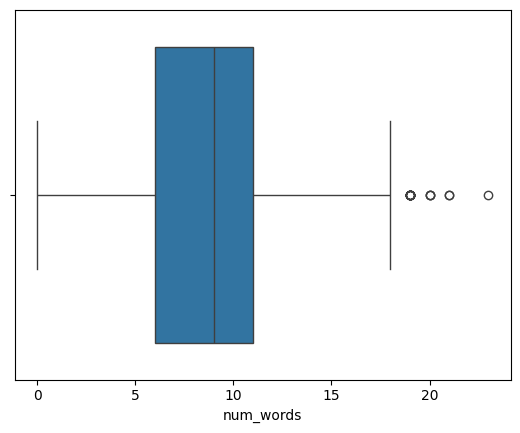

In [78]:
sns.boxplot(x=data)

Заметим, что есть твиты, из которого мы убрали все символы, удалим их

In [79]:
bad_ind = data[data == 0].index
bad_ind.to_list()
df.drop(index=bad_ind, inplace=True)
data.drop(index=bad_ind, inplace=True)

Посмотрим, влияет ли как то размер твитта на метку класса

<ipython-input-80-551133da9f5d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df1, x='num_words', y='label', orient='h', palette='rocket')


<Axes: xlabel='num_words', ylabel='label'>

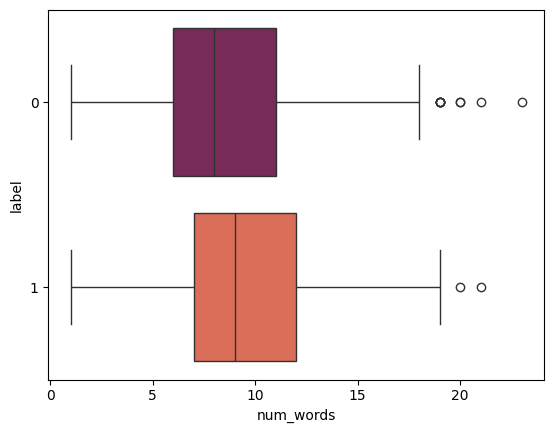

In [80]:
df1 = pd.DataFrame(data)
df1['label'] = df['class_label']
sns.boxplot(data=df1, x='num_words', y='label', orient='h', palette='rocket')

Посмотрим, есть ли какие то слова, которые сразу помогут понять, что нужно поставить метку 1 или 0

In [81]:
first = Counter(' '.join(df[df['class_label'] == 1]['text']).split())
zero = Counter(' '.join(df[df['class_label'] == 0]['text']).split())
d1 = dict(first.most_common(6))
d0 = dict(zero.most_common(6))

[Text(0.5, 1.0, 'Самые популярные слова в твите о катастрофе')]

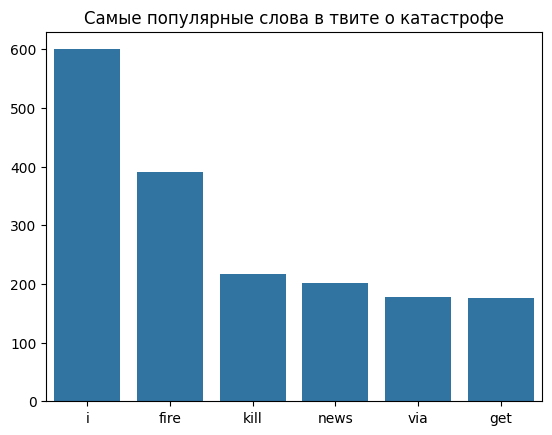

In [82]:
sns.barplot(d1).set(title='Самые популярные слова в твите о катастрофе')

[Text(0.5, 1.0, 'Самые популярные слова в обычном твите')]

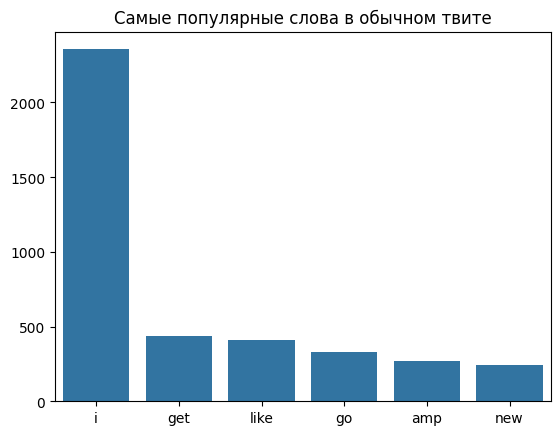

In [83]:
sns.barplot(d0).set(title='Самые популярные слова в обычном твите')

#3
Токенизация

## По словам

**Идея**
<br> Тут используется WordPunctTokenizer - это усовершенствованная версия простого токенайзера. Разбивает на отдельные элементы слова и пунктуацию

In [62]:
tokenizer = WordPunctTokenizer()

In [63]:
df_token_words = df.copy()

In [64]:
def text_to_tokens(text):
  text_tokenized = tokenizer.tokenize(text)
  return text_tokenized

df_token_words['tokens'] = df_token_words['text'].apply(lambda x: text_to_tokens(x))

In [65]:
df_token_words

,text,class_label,tokens
0,happen terrible car crash,1,"[happen, terrible, car, crash]"
1,deed reason earthquake may allah forgive,1,"[deed, reason, earthquake, may, allah, forgive]"
2,hear earthquake different city stay safe everyone,1,"[hear, earthquake, different, city, stay, safe..."
3,forest fire spot pond geese flee across street...,1,"[forest, fire, spot, pond, geese, flee, across..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
...,...,...,...
10866,suicide bomber kill saudi security site mosque...,1,"[suicide, bomber, kill, saudi, security, site,..."
10868,green line derailment chicago,1,"[green, line, derailment, chicago]"
10869,two giant crane hold bridge collapse nearby home,1,"[two, giant, crane, hold, bridge, collapse, ne..."
10873,late home raze northern california wildfire ab...,1,"[late, home, raze, northern, california, wildf..."


## BPE

**Идея**
<br> Допустим у нас есть словарь и текст, который нужно токенизировать. Мы пройдемся по тексту, найдем такую комбинацию символов, которая встречается чаще всего и добавим ее в наш словарь. Теперь мы будем искать такую комбинацию 2х символов или комбинацию символа+комбинации, которая встречается чаще всего, также добавим это в словарь. И так далее
<br> Наверно, это можно назвать - рекурсивным поиском комбинаций(подстрок)

In [84]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

In [85]:
df_token_bpe = df.copy()

In [86]:
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=100, min_frequency=2)
tokenizer.train_from_iterator(df_token_bpe['text'].tolist(), trainer)

def tokenize_text(text):
    encoded = tokenizer.encode(text)
    return encoded.tokens

df_token_bpe['tokens'] = df_token_bpe['text'].apply(tokenize_text)

In [87]:
df_token_bpe

,text,class_label,tokens
0,happen terrible car crash,1,"[h, ap, p, en, ter, ri, b, le, c, ar, c, ra, sh]"
1,deed reason earthquake may allah forgive,1,"[de, e, d, re, a, s, on, e, ar, th, q, u, a, k..."
2,hear earthquake different city stay safe everyone,1,"[h, e, ar, e, ar, th, q, u, a, ke, d, i, f, f,..."
3,forest fire spot pond geese flee across street...,1,"[f, o, re, st, fi, re, s, p, ot, p, on, d, ge,..."
4,forest fire near la ronge sask canada,1,"[f, o, re, st, fi, re, ne, ar, l, a, r, on, ge..."
...,...,...,...
10866,suicide bomber kill saudi security site mosque...,1,"[su, ic, i, de, b, om, b, er, k, il, l, s, a, ..."
10868,green line derailment chicago,1,"[g, re, en, l, in, e, d, er, a, il, m, ent, ch..."
10869,two giant crane hold bridge collapse nearby home,1,"[t, w, o, g, i, an, t, c, r, an, e, h, ol, d, ..."
10873,late home raze northern california wildfire ab...,1,"[l, ate, h, om, e, ra, z, e, n, or, th, er, n,..."


## Berttokenizer

**Идея**
<br> Этот токенизатор использует идею Wordpiece. Wordpiece строит свой словарь похожим образом как и BPE, но в этом методе нам не все равно на положение комбинации в строке:
<br> Если слово не начинается с компбинации, то комб обозначается как ##combination
<br> Если слово начинается с комбинации, то комб обозначается как combination (без решеток)

In [93]:
from transformers import BertTokenizer

In [94]:
df_token_bert = df.copy()

In [95]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [96]:
def tokenize_text(text):
    encoded = tokenizer.tokenize(text)
    return encoded
df_token_bert['tokens'] = df_token_bert['text'].apply(tokenize_text)

In [97]:
df_token_bert

,text,class_label,tokens
0,happen terrible car crash,1,"[happen, terrible, car, crash]"
1,deed reason earthquake may allah forgive,1,"[deed, reason, earthquake, may, allah, forgive]"
2,hear earthquake different city stay safe everyone,1,"[hear, earthquake, different, city, stay, safe..."
3,forest fire spot pond geese flee across street...,1,"[forest, fire, spot, pond, geese, flee, across..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ron, ##ge, sas, ##k, ..."
...,...,...,...
10866,suicide bomber kill saudi security site mosque...,1,"[suicide, bomber, kill, saudi, security, site,..."
10868,green line derailment chicago,1,"[green, line, der, ##ail, ##ment, chicago]"
10869,two giant crane hold bridge collapse nearby home,1,"[two, giant, crane, hold, bridge, collapse, ne..."
10873,late home raze northern california wildfire ab...,1,"[late, home, ra, ##ze, northern, california, w..."


# 4



## Векторизация

**Идея**
<br> TF-IdF метод, позволяющий находить в документе важные слова, отражающие смысл документа.
<br> Состоит из двух множителей:
<br> TF - сколько раз слово встретилось в документе/ кол-во слов в документе
<br> IdF - log ( кол-во документов всего / кол-во документов с этим словом)

In [ ]:
df_vect = df.copy()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matr = vectorizer.fit_transform(df_vect['text'])
tfidf = pd.DataFrame(tfidf_matr.toarray(), columns=vectorizer.get_feature_names_out(), index=df_vect.index)

In [ ]:
tfidf

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaffndcdnq,aahyoeitzl,aan,aannnnd,aapatwork,...,оћmgn,цekdar,щp,ьў,ќmy,ќyeah,ўi,ўif,ўthis,ўоѕ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Можно сделать конкатенацию <br>df_copy_vect = pd.concat([df_copy_vect, tfidf], axis=1) <br>но у меня это, съедает много оперативы(

Убедимся, что хоть где-то tf-idf > 0.
<br> Для предложения из первой строки 'happened terrible car crash' получимм такие значения

In [ ]:
q = tfidf.iloc[0]
q[q>0]

car         0.428903
crash       0.413219
happened    0.537414
terrible    0.597059
Name: 0, dtype: float64

## FastText

**Идея**
<br> Как и в Word2Vec есть разные подходы. Skip-gram (предсказываем слово по контексту) и Cbow (наоборот). Но алгоритм считает, что у нас вместо слов n-граммы. Получив эмбеддинги для разных значений n, усредняет и получает итоговый.
<br> Такой подход получше взаимодействует с редкими словами, сленгом. Возможно, он получше будет работать с нашими твиттами.

In [183]:
df_embed1 = df_token_words.copy()

In [184]:
model = FastText(sentences=df_embed1['tokens'], vector_size=200, window=3, min_count=1, workers=4)

In [185]:
def create_text_emb(text, model):
  ls = [model.wv[word] for word in text if word in model.wv]
  if ls: return np.sum(ls, axis=0)
  else: return np.zeros(model.vector_size)
  # return list(np.sum(ls, axis=0))
df_embed1['FT'] = df_embed1['tokens'].apply(lambda x: create_text_emb(x, model))

In [186]:
df_embed1

,text,class_label,tokens,FT
0,happen terrible car crash,1,"[happen, terrible, car, crash]","[-1.6755841, 0.14975528, 1.1753709, 0.5817287,..."
1,deed reason earthquake may allah forgive,1,"[deed, reason, earthquake, may, allah, forgive]","[-2.1533232, 0.19204432, 1.5065386, 0.7371924,..."
2,hear earthquake different city stay safe everyone,1,"[hear, earthquake, different, city, stay, safe...","[-2.4554875, 0.22439441, 1.726829, 0.84912, 1...."
3,forest fire spot pond geese flee across street...,1,"[forest, fire, spot, pond, geese, flee, across...","[-3.4882035, 0.3132908, 2.4594252, 1.203447, 2..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[-2.4559007, 0.21942644, 1.7344754, 0.85011035..."
...,...,...,...,...
10866,suicide bomber kill saudi security site mosque...,1,"[suicide, bomber, kill, saudi, security, site,...","[-4.839304, 0.47663724, 3.3827987, 1.6344671, ..."
10868,green line derailment chicago,1,"[green, line, derailment, chicago]","[-1.4113481, 0.13189606, 0.99217594, 0.4869977..."
10869,two giant crane hold bridge collapse nearby home,1,"[two, giant, crane, hold, bridge, collapse, ne...","[-2.7335868, 0.24907623, 1.9251591, 0.93141836..."
10873,late home raze northern california wildfire ab...,1,"[late, home, raze, northern, california, wildf...","[-3.10353, 0.27729797, 2.1891003, 1.0554991, 2..."


## С Hugginface

**Идея**
<br> Берем предобученные эмбеддинги полученные от модели JinaBERT

In [ ]:
df_embed2 = df_token_words.copy()

In [ ]:
model = SentenceTransformer(
    "jinaai/jina-embeddings-v2-base-en",
    trust_remote_code=True
)
embeds = model.encode(df_embed2['text'].to_list(), batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/340 [00:00<?, ?it/s]

In [ ]:
df_embed2['HF'] = embeds.tolist()

In [ ]:
df_embed2

,text,class_label,tokens,HF
0,happened terrible car crash,1,"[happened, terrible, car, crash]","[-0.47261548042297363, -0.5244330167770386, 0...."
1,deeds reason earthquake may allah forgive us,1,"[deeds, reason, earthquake, may, allah, forgiv...","[-0.23591971397399902, -0.9669387340545654, 0...."
2,heard earthquake different cities stay safe ev...,1,"[heard, earthquake, different, cities, stay, s...","[-0.12491287291049957, -0.4994921088218689, 0...."
3,forest fire spot pond geese fleeing across str...,1,"[forest, fire, spot, pond, geese, fleeing, acr...","[-0.03518051654100418, -0.583051323890686, 0.3..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[0.5566437840461731, -0.37826529145240784, 0.3..."
...,...,...,...,...
10871,utc volcano hawaii,1,"[utc, volcano, hawaii]","[0.1213802844285965, -0.9765990972518921, 0.65..."
10872,police investigating e bike collided car littl...,1,"[police, investigating, e, bike, collided, car...","[-0.47605571150779724, -0.2642960846424103, 0...."
10873,latest homes razed northern california wildfir...,1,"[latest, homes, razed, northern, california, w...","[-0.3359220027923584, -0.8079306483268738, 0.2..."
10874,meg issues hazardous weather outlook hwo,1,"[meg, issues, hazardous, weather, outlook, hwo]","[0.0764855295419693, -0.4232654273509979, 0.82..."


# 5

## FastText + токенизация по словам

In [187]:
df_FT = df_embed1.copy()
df_FT.drop(['text', 'tokens'], axis=1,inplace=True)

In [188]:
embeds = np.array(df_FT['FT'].tolist())
pcaed = PCA(n_components=2)
comprd = pcaed.fit_transform(embeds)
df_FT['PCA_1'] = comprd[:, 1]
df_FT['PCA_2'] = comprd[:, 0]

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

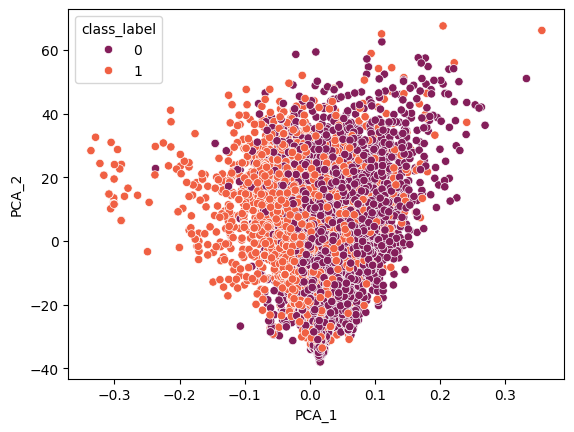

In [189]:
sns.scatterplot(x='PCA_1', y='PCA_2', hue='class_label', data=df_FT, palette='rocket')

## FastText + BertTokenizer

In [105]:
df_embed12 = df_token_bert.copy()

In [112]:
model = FastText(sentences=df_embed12['tokens'], vector_size=100, window=3, min_count=1, workers=4)

In [113]:
def create_text_emb(text, model):
  ls = [model.wv[word] for word in text if word in model.wv]
  if ls: return np.sum(ls, axis=0)
  else: return np.zeros(model.vector_size)
df_embed12['FT'] = df_embed12['tokens'].apply(lambda x: create_text_emb(x, model))

In [114]:
df_embed12

,text,class_label,tokens,FT
0,happen terrible car crash,1,"[happen, terrible, car, crash]","[-0.1869539, 0.33525908, 1.9936953, 3.8797212,..."
1,deed reason earthquake may allah forgive,1,"[deed, reason, earthquake, may, allah, forgive]","[-0.22396998, 0.39025864, 2.5833447, 5.0012894..."
2,hear earthquake different city stay safe everyone,1,"[hear, earthquake, different, city, stay, safe...","[-0.27429745, 0.48517457, 2.9858475, 5.823122,..."
3,forest fire spot pond geese flee across street...,1,"[forest, fire, spot, pond, geese, flee, across...","[-0.39612538, 0.71922404, 4.182466, 8.239131, ..."
4,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ron, ##ge, sas, ##k, ...","[0.09728449, -0.0838871, 4.8830028, 7.8636975,..."
...,...,...,...,...
10866,suicide bomber kill saudi security site mosque...,1,"[suicide, bomber, kill, saudi, security, site,...","[-0.47085246, 1.0092552, 6.026786, 11.671544, ..."
10868,green line derailment chicago,1,"[green, line, der, ##ail, ##ment, chicago]","[-0.05438305, 0.12287716, 3.6124105, 6.1430645..."
10869,two giant crane hold bridge collapse nearby home,1,"[two, giant, crane, hold, bridge, collapse, ne...","[-0.29152995, 0.54589444, 3.3665872, 6.5063314..."
10873,late home raze northern california wildfire ab...,1,"[late, home, ra, ##ze, northern, california, w...","[-0.07567494, 0.34366506, 5.227146, 9.18425, -..."


In [115]:
df_FTBPE = df_embed12.copy()
df_FTBPE.drop(['text', 'tokens'], axis=1,inplace=True)
embeds = np.array(df_FTBPE['FT'].tolist())
pcaed = PCA(n_components=2)
comprd = pcaed.fit_transform(embeds)
df_FTBPE['PCA_1'] = comprd[:, 1]
df_FTBPE['PCA_2'] = comprd[:, 0]

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

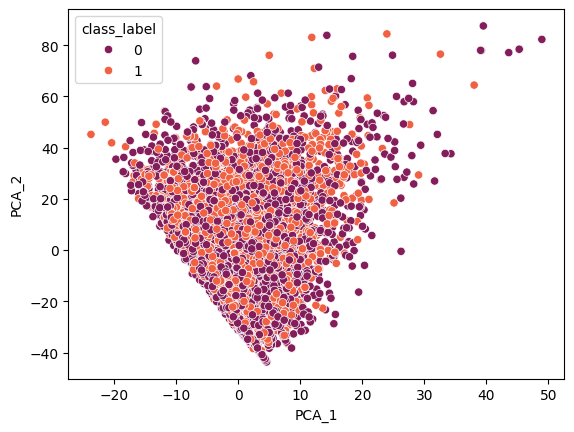

In [116]:
sns.scatterplot(x='PCA_1', y='PCA_2', hue='class_label', data=df_FTBPE, palette='rocket')

## HF + токенизация по словам

In [ ]:
df_hf = df_embed2.copy()
df_hf.drop(['text', 'tokens'], axis=1,inplace=True)

In [ ]:
embeds = np.array(df_hf['HF'].tolist())
pcaed = PCA(n_components=2)
comprd = pcaed.fit_transform(embeds)
df_hf['PCA_1'] = comprd[:, 0]
df_hf['PCA_2'] = comprd[:, 1]

<Axes: xlabel='PCA_1', ylabel='PCA_2'>

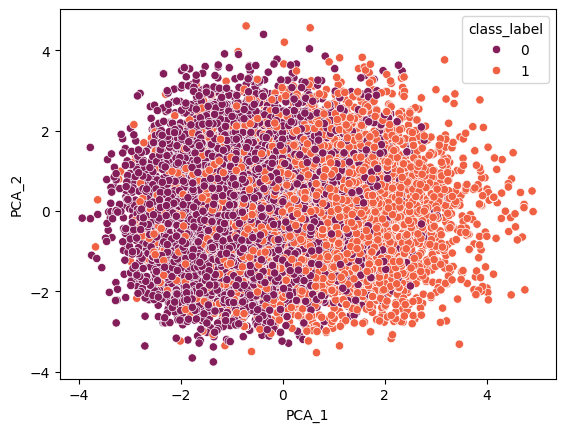

In [ ]:
sns.scatterplot(x='PCA_1', y='PCA_2', hue='class_label', data=df_hf, palette='rocket')

#Итог

Хорошее разделение по итогам сжатия с помощью PCA показали:
<br> - обученный FastText + токенизация по словам
<br> - предобученная модель с HugginFace + токенизация по словам